In [ ]:
# Training policy which maximizes the entropy of state visitation distribution
# st -> Agent -> at -> env -> st+1-> Agent ... repeat
# env = 6*6 matrix

# state is of shape (6,6,2) i.e full envionment states
# cell[5][5][0] = 1 means agent is in the cell, 0 means not in the cell
# cell[5][5][1] = How many times agent visited that state in one episode

# debug
# see loss
# cnn

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import random
import matplotlib.pyplot as plt

In [16]:
epsilon = random.random()
print(epsilon)

0.5264244619795013


In [17]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [18]:
# class Network(nn.Module):
#     def __init__(self, in_channels, num_outputs, base_channels=4):
#         super(Network, self).__init__()
#         self.conv_block1 = nn.Conv2d(in_channels, base_channels, kernel_size=2, stride=1, padding=0)   # 6 -> 5
#         self.conv_block2 = nn.Conv2d(base_channels, 2*base_channels, kernel_size=2, stride=1, padding=0) # 5 -> 4

#         flatten = 2 * base_channels * 4 * 4
#         self.fc1 = nn.Linear(flatten, 60)
#         self.actor = nn.Linear(60, num_outputs)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = F.relu(self.conv_block1(x))  #  [B,4,5,5]
#         x = F.relu(self.conv_block2(x))  #  [B,8,4,4]
#         x = x.reshape(x.size(0), -1)     #  [B,128]
#         x = self.relu(self.fc1(x))       #  [B,30]
#         dist = Categorical(logits=self.actor(x))
#         return dist

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(6*6*2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        x = x.reshape(x.size(0), -1) # flatten
        logits = self.fc(x)
        return Categorical(logits=logits)


In [19]:
lr = 5e-4
model = Network( )
optimizer = optim.Adam(model.parameters(), lr=lr)
eps = 1e-8

In [20]:
# Random policy actions
obs = torch.zeros(6,6,2, dtype = torch.float32)
obs[5][0][0] = 1 # agent is at the buttom left corner
obs[5][0][1] = 1 # it already visited it one time
obs = obs.unsqueeze(0)
obs = obs.permute(0,3,1,2)
for t in range(36):
  dist = model(obs)
  action = dist.sample()
  next_obs = env_step(obs,action)
  obs = next_obs
  print(action.item())

NameError: name 'env_step' is not defined

In [21]:
def env_step(obs, action):
  # if agent tires to go beyond (6,6), ignoring the action and increasing visitation count at that cell
  # find obs[r][c][0] = 1, this means here is the agent
  # make obs[r][c][0] = 0, after taking action agent will not be here
  # 0 = up, 1 = down, 2 = left, 3 = right
  # after taking action let agent reached r',c'. if action is invalid, meaning it goes out of bounds, to take any action
  # increase the count of that state i.e obs[r][c][1] += 1

  # make obs[r'][c'][0] = 1  because agent is here
  # do obs[r'][c'][0] += 1   because agent visited here

  # now return the obs

  obs = obs.clone()
  _, _, H, W = obs.shape
  r, c = torch.where(obs[0, 0] == 1)
  r, c = int(r[0]), int(c[0])

  obs[0, 0, r, c] = 0  # remove agent

  if action == 0 and r > 0: r -= 1         # up
  elif action == 1 and r < H - 1: r += 1   # down
  elif action == 2 and c > 0: c -= 1       # left
  elif action == 3 and c < W - 1: c += 1   # right

  obs[0, 0, r, c] = 1                      # new position
  obs[0, 1, r, c] += 1                     # increment visit
  return obs

# def find_state_distribution(obs):
#   # As we have all information of state visitation count at last observation of the time steps, we can find distribution from here
#   # create (6,6) tesor
#   # for each cell, it distribution is obs[r][c][1]/30
#   # return the distribution
#   visit_count = obs[0, 1]  # shape (6,6)
#   dist = visit_count / visit_count.sum()
#   return dist

# def find_total_dist(dists):
#   # each trajectory ko each reward garum
#   return torch.stack(dists)

In [ ]:
epoches = 100
episodes = 32
gamma = 0.99
baseline = 0
alpha = 0.9
plt_loss = []
for epoch in range(epoches):
  # d_T_pie_s_episodes = []
  prob_sum = []
  batch_losses = []
  batch_reward = []
  for episode in range(episodes):
    obs = torch.zeros(6,6,2, dtype = torch.float32)
    obs[5][0][0] = 1  #  agent is at the buttom left corner
    obs[5][0][1] = 1  #  it already visited it one time
    obs = obs.unsqueeze(0)
    obs = obs.permute(0,3,1,2)
    action_log_prob = []
    rewards = []

    for t in range(36):
      dist = model(obs)
      epsilon = random.random()
      if epsilon < 0.5:
        action = dist.sample()
      else:
        action = torch.tensor(random.randint(0,3))
      action_log_prob.append(dist.log_prob(action))
      next_obs = env_step(obs,action)

      r, c = torch.where(next_obs[0, 0] == 1)
      visit_count = next_obs[0, 1, r, c]
      reward = 10 / (visit_count**5)
      rewards.append(reward)


      obs = next_obs

    rewards = torch.stack(rewards)
    batch_reward.append(rewards.sum())
    future_rewards = []
    discounted_reward = 0
    for reward in reversed(rewards):
      discounted_reward = reward + gamma * discounted_reward
      future_rewards.insert(0, discounted_reward)

    future_rewards = torch.stack(future_rewards)
    # future_rewards = (future_rewards - future_rewards.mean()) / (future_rewards.std() + eps)
    advantages = future_rewards.detach() - baseline
    episode_return = future_rewards[0]
    baseline = alpha * baseline + (1 - alpha) * episode_return.item()

    action_log_prob = torch.stack(action_log_prob)
    policy_loss = (action_log_prob * advantages).sum()

    batch_losses.append(policy_loss)
  # state_distribution = find_total_dist(d_T_pie_s_episodes)
  # entropy_or_reward = torch.stack([ -(d*torch.log(d+eps)).sum() for d in state_distribution ])
  # rough backprop flow is entropy → state_distribution → d_T_pie_s_episodes → d_T_pie_s → obs → action --sample()-- → model
  # we can't backpropagate through this because dist.sample() is non-differentiable
  # so using reinforce
  # loss = -(torch.stack(prob_sum) * entropy_or_reward).mean()

  print(f" reward: {torch.stack(batch_reward).mean()} ")
  optimizer.zero_grad()
  loss = torch.stack(batch_losses).mean()
  if epoch%10 == 0:
    # print(f"epoch: {epoch}")
    # print(f"entropy: {entropy_or_reward}")
    # print(f"loss at epoch: {loss}")
    # total_norm = 0
    # for p in model.parameters():
    #   if p.grad is not None:
    #     total_norm += p.grad.data.norm(2).item()**2
    # total_norm = total_norm**0.5
    # print("grad norm:", total_norm)
    print(f"Epoch {epoch}, Loss: {loss.item():.3f}, Baseline: {baseline:.3f}")
  plt_loss.append(loss.item())
  loss.backward()
  optimizer.step()

 reward: 110.14320373535156 
Epoch 0, Loss: 23498.785, Baseline: 98.098
 reward: 105.99908447265625 
 reward: 105.03401947021484 
 reward: 98.7079849243164 
 reward: 110.43074798583984 
 reward: 115.28547668457031 
 reward: 98.96621704101562 
 reward: 103.23670959472656 
 reward: 116.29521942138672 
 reward: 108.81330108642578 
 reward: 111.3518295288086 
Epoch 10, Loss: 40385.215, Baseline: 100.510
 reward: 101.56619262695312 
 reward: 113.21635437011719 
 reward: 102.9940185546875 
 reward: 112.9616470336914 
 reward: 112.61947631835938 
 reward: 108.95061492919922 
 reward: 115.31959533691406 
 reward: 107.2696762084961 
 reward: 101.86776733398438 
 reward: 102.29410552978516 
Epoch 20, Loss: 29161.465, Baseline: 92.945
 reward: 117.39889526367188 
 reward: 108.71004486083984 
 reward: 106.5633316040039 
 reward: 103.29369354248047 
 reward: 105.25814819335938 
 reward: 110.4068603515625 
 reward: 106.9803695678711 
 reward: 111.49009704589844 
 reward: 103.20574188232422 
 reward:

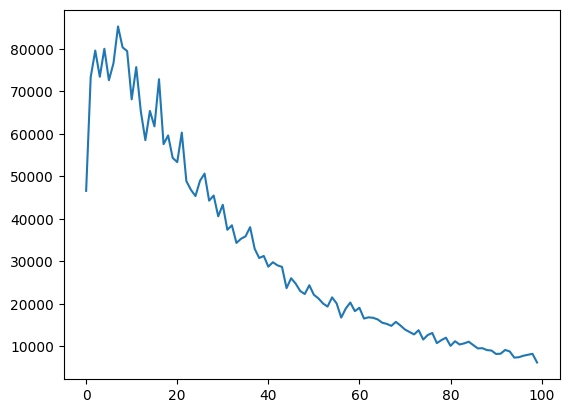

In [30]:
# eps = 1e-8
# d_T_pie_s_episodes = [torch.ones(6,6),torch.ones(6,6), torch.ones(6,6)]
# state_distribution = find_total_dist(d_T_pie_s_episodes)
# print(state_distribution.shape)
# entropy_or_reward = torch.stack([ -(d*torch.log(d+eps)).sum()
#                                 for d in state_distribution ])
# print(entropy_or_reward.shape)
plt.plot(plt_loss)
plt.show()

In [31]:
# trained policy
obs = torch.zeros(6,6,2, dtype = torch.float32)
obs[5][0][0] = 1 # agent is at the buttom left corner
obs[5][0][1] = 1 # it already visited it one time
obs = obs.unsqueeze(0)
obs = obs.permute(0,3,1,2)
for t in range(36):
  dist = model(obs)
  action = dist.sample()
  next_obs = env_step(obs,action)
  obs = next_obs
  print(action.item())

3
3
2
3
2
0
3
3
3
3
3
3
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


In [32]:
obs.shape
obs = obs.squeeze(0)
obs.shape
obs = obs.permute(1,2,0)
print(obs.shape)


torch.Size([6, 6, 2])


In [33]:
obs

tensor([[[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 1., 24.]],

        [[ 0.,  0.],
         [ 0.,  1.],
         [ 0.,  1.],
         [ 0.,  1.],
         [ 0.,  1.],
         [ 0.,  3.]],

        [[ 0.,  1.],
         [ 0.,  3.],
         [ 0.,  2.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]])

In [28]:
r, c = torch.where(next_obs[0, 0] == 1)
visit_count = next_obs[0, 1, r, c]
print(visit_count)
reward = 10 / (visit_count**5)
print(reward)

tensor([32.])
tensor([2.9802e-07])
